In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from collections import Counter

In [2]:
dir_path = "images"

## Train and Test Data distribution

In [3]:
test_datapoint = 0
train_datapoint = 0
for i in os.listdir(dir_path):
    if i.split("_")[0]=='Test':
        test_datapoint += 1
    else:
        train_datapoint += 1

In [4]:
plt.bar(['Train',"Test"], height = [train_datapoint, test_datapoint])

<BarContainer object of 2 artists>

In [5]:
print("Total number of Train Data points = ", train_datapoint)
print("Total number of Test Data points = ", test_datapoint)

Total number of Train Data points =  1821
Total number of Test Data points =  1821


## Size distribution of Images

In [6]:
##Getting size of images
list_of_heights = []
list_of_widths = []
for i in os.listdir(dir_path):
    img = cv2.imread(os.path.join(dir_path,i), cv2.IMREAD_UNCHANGED)
    shape = img.shape
    break
    list_of_heights.append(shape[0])
    list_of_widths.append(shape[1]) 

In [7]:
shape

(1365, 2048, 3)

In [6]:
d = Counter(list_of_heights)
for i,j in d.items():
    print("There as",j,"images with",i,"height")

There as 498 images with 1365 height
There as 5 images with 2048 height


In [7]:
d = Counter(list_of_widths)
for i,j in d.items():
    print("There as",j,"images with",i,"width")

ERROR! Session/line number was not unique in database. History logging moved to new session 1639
There as 498 images with 2048 width
There as 5 images with 1365 width


#### Hence most of the images have the height of 1365, and width of 2048.
#### Rest of the images are rotated images

## Label Distribution of the Images in Train Data
* Test Data does not has labels

In [8]:
df = pd.read_csv('train.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


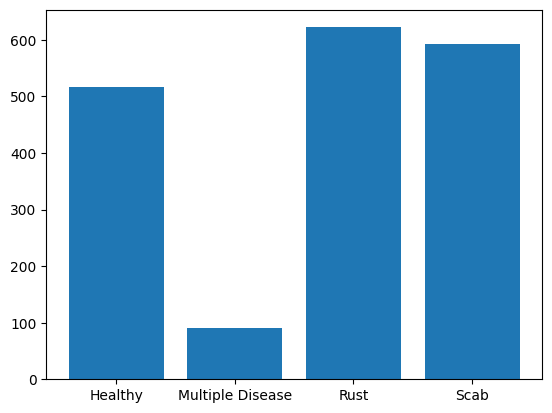

In [14]:
plt.bar([1,2,3,4],[df.healthy.value_counts()[1],df.multiple_diseases.value_counts()[1],df.rust.value_counts()[1],df.scab.value_counts()[1]])
plt.xticks([1,2,3,4],["Healthy", "Multiple Disease", "Rust", "Scab"])
plt.savefig('distribution.png')
plt.show()

#### The data is Imbalanced, there are lesser number of data points with "multiple_disease" label
#### Here we have to build a model which takes a leaf image and classify it among one of the classes.
#### The model perforance will be judged based on the average AUC ROC score of all the four categories

## Image Generator

In [11]:
##Getting image directories
list_of_train_data = []
for i in df.image_id:
    list_of_train_data.append(os.path.join(dir_path,i+".jpg"))

In [12]:
list_of_train_data[:5]

['images\\Train_0.jpg',
 'images\\Train_1.jpg',
 'images\\Train_2.jpg',
 'images\\Train_3.jpg',
 'images\\Train_4.jpg']

In [33]:
train_image_labels_mapping = {'healthy':0, "multiple_diseases":1, "rust":2, "scab":3}

In [78]:
train_image_labels = []
for i in df.values:
    train_image_labels.append(np.where(i[1:]==1)[0][0])

#### Sanity Check

In [79]:
df.head(5)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [80]:
list_of_train_data[:5]

['images\\Train_0.jpg',
 'images\\Train_1.jpg',
 'images\\Train_2.jpg',
 'images\\Train_3.jpg',
 'images\\Train_4.jpg']

In [82]:
train_image_labels[:5]

[3, 1, 0, 2, 0]

#### I used the Image generator from my previous assignment

In [53]:
def tfdata_generator(images, labels, is_training, batch_size=32):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename,labels):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        image = tf.image.resize(image, [156, 256])
        
        y = tf.one_hot(tf.cast(labels, tf.uint8), 4)
        #print(y)
        return image,y
    
    def flip(image,labels):
        
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        
        return image,labels
    
    def rotate(image,labels):

        return tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)),labels
    
    def color(image,labels):
        image = tf.image.random_hue(image, 0.08)
        image = tf.image.random_saturation(image, 0.6, 1.6)
        image = tf.image.random_brightness(image, 0.05)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        return image,labels
    
    dataset = tf.data.Dataset.from_tensor_slices((images,labels))
    
    if is_training:
        dataset = dataset.shuffle(5000)  # depends on sample size
        
    # Transform and batch data at the same time
    dataset = dataset.map(parse_function, num_parallel_calls=4)
    
    augmentations = [flip,rotate,color]
    
    if is_training:
        for f in augmentations:
            if np.random.uniform(0,1)>0.6:
                dataset = dataset.map(f,num_parallel_calls=4)
    
    dataset = dataset.repeat()
    
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [54]:
tf_image_generator = tfdata_generator(list_of_train_data, train_image_labels, True, batch_size=32)

In [55]:
tf_image_generator

<PrefetchDataset shapes: ((156, 256, 3), (4,)), types: (tf.float32, tf.float32)>

(156, 256, 3) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


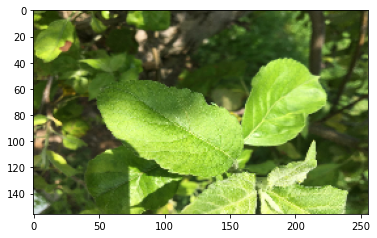

In [72]:
for x, y in tf_image_generator:
    print(x.shape, y)
    plt.imshow(x)
    break

(156, 256, 3) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


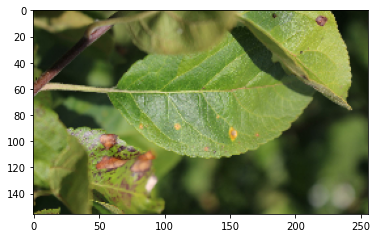

In [62]:
for x, y in tf_image_generator:
    print(x.shape, y)
    plt.imshow(x)
    break

(156, 256, 3) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


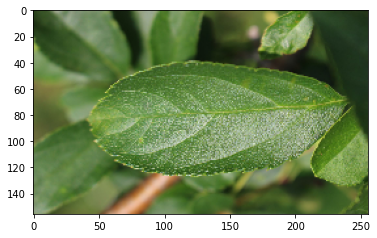

In [83]:
for x, y in tf_image_generator:
    print(x.shape, y)
    plt.imshow(x)
    break

(156, 256, 3) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


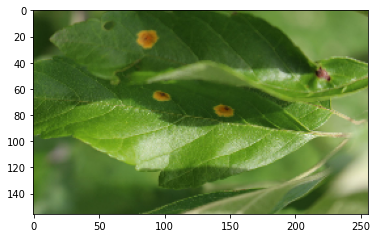

In [84]:
for x, y in tf_image_generator:
    print(x.shape, y)
    plt.imshow(x)
    break

(156, 256, 3) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


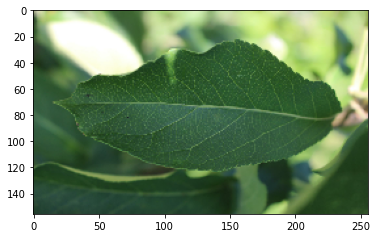

In [86]:
for x, y in tf_image_generator:
    print(x.shape, y)
    plt.imshow(x)
    break